In [2]:
# IMPORTS AND UTILS

import torch
import os
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CTCLoss
import torch.optim.lr_scheduler as lr_scheduler

# DEVICE DEFINITION

device="cpu"

# BOUNDING BOX FUNCTION 

def get_bounding_box(file):
    numbers=file.split("-")
    values=numbers[3]
    values_v2=values.split("&")
    values_v3=[]
    for i in range(len(values_v2)):
        if "_" in values_v2[i]:
            values_v3.append(values_v2[i].split("_"))
    t=[values_v2[0],values_v3[0],values_v3[1],values_v3[2],values_v2[-1]]
    final_values = [int(x) for item in t for x in (item if isinstance(item, list) else [item])]
    x_coords=[final_values[0],final_values[2],final_values[4],final_values[6]]
    y_coords=[final_values[1],final_values[3],final_values[5],final_values[7]]
    x_min = min(x_coords)
    y_min = min(y_coords)
    x_max = max(x_coords)
    y_max = max(y_coords)
    return [float(x_min), float(y_min), float(x_max), float(y_max)]

# LOAD FASTER RCNN MODEL

def load_Fasterrcnn(device):
    model = fasterrcnn_resnet50_fpn(num_classes=2)  
    model.load_state_dict(torch.load('best_frcnn_model _final_version.pth',map_location="cpu"))
    model.to(device)
    model.eval()
    return model

model=load_Fasterrcnn("cpu")

# CAR PLATE TEXT FUNCTION

provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabet = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

MY_DICTIONARY = provinces + [c for c in alphabet if c not in provinces] + [c for c in ads if c not in provinces and c not in alphabet]    
MY_DICTIONARY = list(dict.fromkeys(MY_DICTIONARY))  
char2idx = {c: i for i, c in enumerate(MY_DICTIONARY)}
idx2char = {i: c for i, c in enumerate(MY_DICTIONARY)}
BLANK_IDX = len(MY_DICTIONARY)  

def get_text(file):
    values=file.split("-")
    text=str(values[4])
    indices=text.split("_")
    province_character=provinces[int(indices[0])]
    alphabet_character=alphabet[int(indices[1])]
    ads_charachters=[ads[int(i)] for i in indices[2:]]
    plate_text=province_character+alphabet_character+"".join(ads_charachters)
    return plate_text

# CROP FUNCTION WITH PREDICTED BOUNDING BOX

def crop_image_with_RCNN(file):
    image = Image.open(file).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(image).unsqueeze(0).to(device) 
    with torch.no_grad():
        prediction = model(img_tensor)[0]
        if len(prediction['boxes']) == 0:
            print(f"No box found for image: {file}")
            return None
        best_bb = prediction['boxes'][0].to(device).int()
        cropped = img_tensor[0, :, best_bb[1]:best_bb[3], best_bb[0]:best_bb[2]]
        cropped_resized = F.interpolate(cropped.unsqueeze(0), size=(48, 144), mode='bilinear', align_corners=False)
        return cropped_resized.squeeze(0)  

def crop_folder_with_RCNN(folder_path):
    cropped_folder = []
    files = os.listdir(folder_path)
    for file in files:
        full_path = os.path.join(folder_path, file)
        gt_text=get_text(full_path)
        cropped_image = crop_image_with_RCNN(full_path)
        if cropped_image is not None:
            cropped_folder.append([cropped_image, gt_text])
    return cropped_folder

def crop_image_with_ground_truth(full_path):
    filename = os.path.basename(full_path)  
    bb = get_bounding_box(filename)
    image = Image.open(full_path).convert("RGB")
    transform = T.ToTensor()
    img_tensor = transform(image)
    cropped = img_tensor[:, int(bb[1]):int(bb[3]), int(bb[0]):int(bb[2])]
    cropped_resized = F.interpolate(cropped.unsqueeze(0), size=(48, 144), mode='bilinear', align_corners=False)
    return cropped_resized.squeeze(0)

def crop_folder_with_ground_truth(folder_path):
    cropped_folder = []
    files = os.listdir(folder_path)
    for file in files:
        full_path = os.path.join(folder_path, file)
        gt_text = get_text(file)  # Get ground truth text
        cropped_image = crop_image_with_ground_truth(full_path)
        cropped_folder.append([cropped_image, gt_text])  # Store image and text pair
    return cropped_folder

def encode_labels(label_list, char2idx, max_len=8):
    encoded = []
    for label in label_list:
        label = label[:max_len].ljust(max_len)
        encoded.append([char2idx[c] for c in label])
    return torch.tensor(encoded, dtype=torch.long)

def ctc_collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images)
    label_lengths = torch.tensor([len(l) for l in labels], dtype=torch.long)
    labels = torch.cat([encode_labels([l], char2idx) for l in labels])
    return images, labels, label_lengths

def ctc_greedy_decoder(output, idx2char, blank=0):
    out = output.permute(1, 0, 2) 
    pred_strings = []
    for probs in out:
        pred = probs.argmax(1).cpu().numpy()
        prev = -1
        pred_str = []
        for p in pred:
            if p != blank and p != prev:
                pred_str.append(idx2char[p])
            prev = p
        pred_strings.append(''.join(pred_str))
    return pred_strings

/tmp/ipykernel_12908/776126894.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_frcnn_model _final_version.pth',map_location="cpu"

In [6]:
# PDLPR MODEL FOLLOWING PAPER ARCHITECTURE

# --- Focus Structure Module ---
class Focus(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, dropout=0.1):
        super(Focus, self).__init__()
        self.conv = nn.Conv2d(in_channels * 4, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Slice and concat
        patch1 = x[..., ::2, ::2]
        patch2 = x[..., ::2, 1::2]
        patch3 = x[..., 1::2, ::2]
        patch4 = x[..., 1::2, 1::2]
        x = torch.cat([patch1, patch2, patch3, patch4], dim=1)
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.dropout(x)
        return x


# --- CNN Block used in RESBLOCK and downsampling ---
def conv_block(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )


# --- Residual Block ---
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            conv_block(channels, channels),
            conv_block(channels, channels)
        )

    def forward(self, x):
        return x + self.block(x)


# --- IGFE Module ---
class IGFE(nn.Module):
    def __init__(self, dropout=0.1):
        super(IGFE, self).__init__()
        self.focus = Focus(3, 64, dropout)
        self.down1 = conv_block(64, 128, stride=2)
        self.res1 = ResBlock(128)
        self.res2 = ResBlock(128)
        self.down2 = conv_block(128, 256, stride=2)
        self.res3 = ResBlock(256)
        self.res4 = ResBlock(256)
        self.final_conv = nn.Conv2d(256, 512, kernel_size=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 18))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.focus(x)
        x = self.down1(x)
        x = self.dropout(x)
        x = self.res1(x)
        x = self.res2(x)
        x = self.down2(x)
        x = self.dropout(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.final_conv(x)
        x = self.adaptive_pool(x)
        return x


# --- Positional Encoding for 2D feature maps ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, height, width):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(1, d_model, height, width))

    def forward(self, x):
        return x + self.pe


# --- Transformer Encoder Block ---
class EncoderBlock(nn.Module):
    def __init__(self, d_model):
        super(EncoderBlock, self).__init__()
        self.cnn1 = nn.Conv2d(d_model, d_model * 2, kernel_size=1)
        self.attn = nn.MultiheadAttention(d_model * 2, num_heads=8, batch_first=True)
        self.cnn2 = nn.Conv2d(d_model * 2, d_model, kernel_size=1)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.cnn1(x)  # [B, 1024, H, W]
        x_ = x.flatten(2).transpose(1, 2)  # [B, HW, 1024]
        x_, _ = self.attn(x_, x_, x_)
        x_ = x_.transpose(1, 2).view(B, -1, H, W)  # [B, 1024, H, W]
        x = self.cnn2(x_)
        return self.norm(x.flatten(2).transpose(1, 2)).transpose(1, 2).view(B, C, H, W)

# --- Parallel Decoder Block ---
class DecoderBlock(nn.Module):
    def __init__(self, d_model):
        super(DecoderBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(d_model, num_heads=8, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 2),
            nn.ReLU(),
            nn.Linear(d_model * 2, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

    def forward(self, tgt, memory):
        # Masked self-attention (causal)
        B, T, _ = tgt.shape
        mask = torch.triu(torch.ones(T, T), diagonal=1).bool().to(tgt.device)
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=mask)
        tgt = self.norm1(tgt + tgt2)

        # Cross-attention
        tgt2, _ = self.cross_attn(tgt, memory, memory)
        tgt = self.norm2(tgt + tgt2)

        # Feedforward
        tgt2 = self.ffn(tgt)
        tgt = self.norm3(tgt + tgt2)
        return tgt


# --- Full PDLPR Recognition Model ---
class PDLPR(nn.Module):
    def __init__(self, num_classes, dropout=0.1):
        super(PDLPR, self).__init__()
        self.igfe = IGFE(dropout)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((6, 18))
        self.pos_encoding = PositionalEncoding(512, 6, 18)
        self.encoder = nn.Sequential(*[EncoderBlock(512) for _ in range(3)])
        self.flatten = lambda x: x.flatten(2).transpose(1, 2)
        self.decoder_blocks = nn.ModuleList([DecoderBlock(512) for _ in range(3)])
        self.cls_head = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, tgt_seq):
        # Clean up any GPU memory
        torch.cuda.empty_cache()
        
        x = self.igfe(x)                     
        x = self.adaptive_pool(x)            
        x = self.dropout(x)
        x = self.pos_encoding(x)
        x = self.encoder(x)
        memory = self.flatten(x)             

        tgt = tgt_seq                        
        for block in self.decoder_blocks:
            tgt = block(tgt, memory)
            tgt = self.dropout(tgt)

        logits = self.cls_head(tgt)
        return logits

In [8]:
# CHOICE OF THE DATASET

class CroppedImages(Dataset):
    def __init__(self, folder, transformations):
        self.folder = folder
        self.transformations = transformations

    def __len__(self):
        return len(self.folder)

    def __getitem__(self, idx):
        try:
            image = self.folder[idx][0]
            gt_text = self.folder[idx][1]
            
            if image is None:
                raise ValueError(f"None image at index {idx}")
                
            if self.transformations:
                image = self.transformations(image)
                
            return image, gt_text
            
        except Exception as e:
            print(f"Error loading sample {idx}: {str(e)}")
            return torch.zeros(3, 48, 144), ""

model=load_Fasterrcnn(device="cpu")
device="cpu"
model.eval()

# Updated transformations with better normalization and data augmentation
trans = T.Compose([
    T.Resize((48, 144), antialias=True),
    T.ColorJitter(brightness=0.2, contrast=0.2),  # Add some color variation
    T.RandomApply([T.GaussianBlur(3, sigma=(0.1, 0.2))], p=0.3),  # Occasional blur
    T.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                std=[0.229, 0.224, 0.225])
])

cropped_folder_train=crop_folder_with_RCNN("/home/filippo/Documents/Visual Studio Code/Computer_Vision/Prove/single_sample_train")
cropped_folder_eval=crop_folder_with_RCNN("/home/filippo/Documents/Visual Studio Code/Computer_Vision/Prove/single_sample_eval")

train_dataset = CroppedImages(cropped_folder_train, trans)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=False, collate_fn=ctc_collate_fn)

eval_dataset = CroppedImages(cropped_folder_eval, trans)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, shuffle=False, collate_fn=ctc_collate_fn)

/tmp/ipykernel_12908/776126894.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_frcnn_model _final_version.pth',map_location="cpu"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7622341..1.2607107].


Encoded ground truth: [0, 35, 37, 58, 61, 67, 64, 58]
Decoded ground truth: 皖BD03960


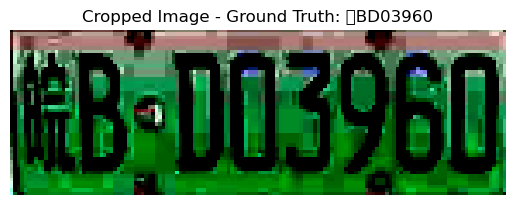

In [11]:
train_item=next(iter(train_dataloader)) 
# returns a dataloader in which each item is a tuple (element in position 0: cropped image with shape [3, 48, 144], element in position 1: a 1X8 tensor of encoded car text,
# element in position 2: a tensor with (8))
image = train_item[0].squeeze()
encoded_text = train_item[1]
text_length = train_item[2]

# Decode the ground truth text
decoded_text = ''.join([idx2char[idx.item()] for idx in encoded_text[0][:text_length[0]]])

print(f"Encoded ground truth: {encoded_text[0].tolist()}")
print(f"Decoded ground truth: {decoded_text}")

# showing the image (if the image sucks put trans=None in the above cell and run again)
plt.imshow(image.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.title(f"Cropped Image - Ground Truth: {decoded_text}")
plt.show()


In [7]:
# COMPLETE PDLPR TRAINING AND EVALUATION WITH CTC LOSS

# Device setup 
device = torch.device("cpu")

# Model setup
model = PDLPR(num_classes=len(MY_DICTIONARY)+1, dropout=0.1).to(device)
criterion = CTCLoss(blank=BLANK_IDX, zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0005)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min', 
    factor=0.7,
    patience=3,
    verbose=True,
    min_lr=1e-6
)

# Training parameters
num_epochs = 15
best_val_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    true_train_accuracy = 0

    for batch_idx, (batch_images, batch_labels, label_lengths) in enumerate(train_dataloader):
        try:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            label_lengths = label_lengths.to(device)
            
            optimizer.zero_grad()
            
            B = batch_images.size(0)
            tgt_seq = torch.zeros(B, 8, 512).to(device)
            
            # Forward pass 
            logits = model(batch_images, tgt_seq)
            log_probs = logits.log_softmax(2)
            
            input_lengths = torch.full(size=(B,), 
                                    fill_value=8,
                                    dtype=torch.long,
                                    device=device)
            
            # Calculate CTC loss
            loss = criterion(log_probs.permute(1, 0, 2),
                           batch_labels,
                           input_lengths,
                           label_lengths)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy using CTC decoder
            pred_text = ctc_greedy_decoder(log_probs.permute(1, 0, 2), idx2char)
            for i in range(B):
                true_text = ''.join([idx2char[idx.item()] for idx in batch_labels[i][:label_lengths[i]]])
                if pred_text[i] == true_text:
                    true_train_accuracy += 1

            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}: Loss = {loss.item():.4f}")

        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            continue

    avg_train_loss = train_loss / len(train_dataloader)
    true_train_acc = true_train_accuracy / (len(train_dataloader) * B)

    # Evaluation phase
    model.eval()
    val_loss = 0
    true_val_accuracy = 0

    with torch.no_grad():
        for batch_images, batch_labels, label_lengths in eval_dataloader:
            batch_images = batch_images.to(device)
            batch_labels = batch_labels.to(device)
            label_lengths = label_lengths.to(device)

            B = batch_images.size(0)
            tgt_seq = torch.zeros(B, 8, 512).to(device)

            logits = model(batch_images, tgt_seq)
            log_probs = logits.log_softmax(2)

            input_lengths = torch.full(size=(B,), 
                                    fill_value=8,
                                    dtype=torch.long,
                                    device=device)

            loss = criterion(log_probs.permute(1, 0, 2),
                           batch_labels,
                           input_lengths,
                           label_lengths)

            val_loss += loss.item()

            # Calculate accuracy using CTC decoder
            pred_text = ctc_greedy_decoder(log_probs.permute(1, 0, 2), idx2char)
            for i in range(B):
                true_text = ''.join([idx2char[idx.item()] for idx in batch_labels[i][:label_lengths[i]]])
                if pred_text[i] == true_text:
                    true_val_accuracy += 1

    avg_val_loss = val_loss / len(eval_dataloader)
    true_val_acc = true_val_accuracy / (len(eval_dataloader) * B)

    # Learning rate scheduling
    scheduler.step(avg_val_loss)

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'epoch': epoch,
            'best_val_loss': best_val_loss
        }, 'best_pdlpr_model_ctc.pth')
        print(f"Saved new best model with validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1

    # Print epoch statistics
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f} | True Train Accuracy: {true_train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | True Val Accuracy: {true_val_acc:.4f}")
    print(f"Current Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    print("-" * 50)

    # Early stopping
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs")
        break

/home/filippo/miniconda3/envs/virtualenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/home/filippo/miniconda3/envs/virtualenv/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Batch 0: Loss = 4.1541
Saved new best model with validation loss: 4.6602

Epoch 1/15
Train Loss: 4.1541 | True Train Accuracy: 0.0000
Val Loss: 4.6602 | True Val Accuracy: 0.0000
Current Learning Rate: 0.000500
--------------------------------------------------
Batch 0: Loss = 2.7617
Saved new best model with validation loss: 4.0939

Epoch 2/15
Train Loss: 2.7617 | True Train Accuracy: 0.0000
Val Loss: 4.0939 | True Val Accuracy: 0.0000
Current Learning Rate: 0.000500
--------------------------------------------------
Batch 0: Loss = 3.0619

Epoch 3/15
Train Loss: 3.0619 | True Train Accuracy: 0.0000
Val Loss: 4.4631 | True Val Accuracy: 0.0000
Current Learning Rate: 0.000500
--------------------------------------------------
Batch 0: Loss = 2.1961

Epoch 4/15
Train Loss: 2.1961 | True Train Accuracy: 0.0000
Val Loss: 4.8479 | True Val Accuracy: 0.0000
Current Learning Rate: 0.000500
--------------------------------------------------
Batch 0: Loss = 2.3496

Epoch 5/15
Train Loss: 2.349

In [35]:
checkpoint = torch.load('best_pdlpr_model_ctc.pth', map_location=device)
model = PDLPR(num_classes=len(MY_DICTIONARY) + 1, dropout=0.1)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

cropped_image=crop_image_with_ground_truth("/home/filippo/Documents/Visual Studio Code/Computer_Vision/Prove/single_sample_eval//03625-92_266-225&396_573&501-568&501_227&490_225&396_573&414-0_0_3_17_25_28_27_30-102-83.jpg")
transformed = trans(cropped_image).unsqueeze(0).to(device)  

tgt_seq = torch.zeros(1, 8, 512).to(device)  # batch size = 1, seq len = 8

# ---- Inference ----
with torch.no_grad():
    logits = model(transformed, tgt_seq)         # [B, T, num_classes]
    log_probs = logits.log_softmax(2)
pred_text = ctc_greedy_decoder(log_probs, idx2char, blank=0)
print(f"Predicted license plate: {pred_text}")

/tmp/ipykernel_9813/160895573.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_pdlpr_model_ctc.pth', map_location=device)


Predicted license plate: ['0', '0', '0', '0', '0', '0', '0', '0']
